In [ ]:
'''
The codes below are the CycleGAN model on the dataset containing with parasites and with artifacts.
Referencing codes the tutorial of CycleGAN by Jason Brownlee. 
Title: How to Develop a CycleGAN for Image-to-Image Translation with Keras
URL: https://machinelearningmastery.com/cyclegan-tutorial-with-keras/

To train, 
1.if not using google colab, then delete the first block about mounting into google drive.
2.check all path 
3.run all the blocks until where stated "To start training directly"
4.if this is the first time for training, then run the section "To start training directly"
if want to start with the saved model, then skip the section "To start training directly" and run the section "To start training from a saved model" 

To perform image translation using saved CycleGAN models,
1.if not using google colab, then delete the first block about mounting into google drive.
2.check all path 
3.start from the section "Using saved CycleGAN models for image translation" and run each blocks after
'''

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -u gdrive/MyDrive/cropped.zip -d /content

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio("cropped", output="my_data", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 11274 files [00:01, 8521.65 files/s]


In [ ]:
# preparing dataset
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
 
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)
 
# dataset path
path = 'my_data_ready/'
# load dataset A -> good
dataA1 = load_images(path + 'trainA/')
dataA2 = load_images(path + 'testA/')
dataA = vstack((dataA1, dataA2))
print('Loaded dataA: ', dataA.shape)
# load dataset B -> bad
dataB1 = load_images(path + 'trainB/')
dataB2 = load_images(path + 'testB/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = 'bad2good_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (4964, 256, 256, 3)
Loaded dataB:  (6310, 256, 256, 3)
Saved dataset:  bad2good_256.npz


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-jzed_703
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-jzed_703
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=85c193aa6f5fe209fbbb915e8919afb73926665ebdec8b1348d0d4c9cbf8cc25
  Stored in directory: /tmp/pip-ephem-wheel-cache-cfrnq6h0/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5), loss_weights=[0.5])
	# model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	# print(model.summary())
	return model

In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	# print(model.summary())
	return model

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0001, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['binary_crossentropy', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model


In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA, d_model_A, d_model_B, c_model_AtoB, c_model_BtoA):
	# save the first generator model
	filename1 = 'gdrive/MyDrive/g_model_AtoB/g_model_AtoB_%06d.h5' % (step+328000+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'gdrive/MyDrive/g_model_BtoA/g_model_BtoA_%06d.h5' % (step+328000+1)
	g_model_BtoA.save(filename2)
	# save the discriminator model 
	filename3 = 'gdrive/MyDrive/d_model_A/d_model_A_%06d.h5' % (step+328000+1)
	d_model_A.save(filename3)
	# save the discriminator model 
	filename4 = 'gdrive/MyDrive/d_model_B/d_model_B_%06d.h5' % (step+328000+1)
	d_model_B.save(filename4)
	# save the second generator model
	filename5 = 'gdrive/MyDrive/c_model_AtoB/c_model_AtoB_%06d.h5' % (step+328000+1)
	c_model_AtoB.save(filename5)
	# save the second generator model
	filename6 = 'gdrive/MyDrive/c_model_BtoA/c_model_BtoA_%06d.h5' % (step+328000+1)
	c_model_BtoA.save(filename6)	
	print('>Saved: %s, %s, %s, %s, %s, %s' % (filename1, filename2,filename3,filename4,filename5,filename6))

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = 'gdrive/MyDrive/generated_plot/%s_generated_plot_%06d.png' % (name, (step+328000+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)


In [ ]:

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# print('check')
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	print(n_steps)
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % 1000 == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % 1000 == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA, d_model_A, d_model_B, c_model_AtoB, c_model_BtoA)


# To start training directly

In [ ]:
# load image data
dataset = load_real_samples('gdrive/MyDrive/bad2good_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

Loaded (4964, 256, 256, 3) (6310, 256, 256, 3)


In [ ]:
training = True

# generator: A -> B
g_model_AtoB = define_generator(image_shape,training)
# generator: B -> A
g_model_BtoA = define_generator(image_shape,training)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Streaming output truncated to the last 5000 lines.
>153758, dA[2.320,0.726] dB[0.611,1.541] g[8.046,10.064]
>153759, dA[1.237,0.922] dB[0.850,1.435] g[4.019,4.815]
>153760, dA[1.247,0.696] dB[0.682,1.528] g[3.637,5.237]
>153761, dA[1.708,0.674] dB[0.635,1.183] g[4.383,4.467]
>153762, dA[1.851,0.788] dB[0.596,1.522] g[5.499,5.167]
>153763, dA[1.437,0.728] dB[0.615,1.489] g[8.395,7.868]
>153764, dA[1.652,0.727] dB[0.722,1.558] g[6.104,5.098]
>153765, dA[1.845,0.876] dB[0.785,1.878] g[6.800,7.220]
>153766, dA[1.495,0.958] dB[0.738,1.442] g[5.246,6.868]
>153767, dA[1.921,1.044] dB[0.703,1.423] g[4.740,6.691]
>153768, dA[1.497,0.987] dB[0.640,1.546] g[7.058,7.399]
>153769, dA[1.479,0.722] dB[0.761,1.477] g[4.047,4.669]
>153770, dA[1.293,1.420] dB[0.707,1.361] g[4.625,7.722]
>153771, dA[1.333,0.989] dB[0.652,1.498] g[5.606,7.408]
>153772, dA[1.472,0.876] dB[0.673,1.625] g[3.528,4.261]
>153773, dA[1.308,0.774] dB[0.611,1.527] g[3.709,5.105]
>153774, dA[2.670,1.143] dB[0.712,1.546] g[4.468,6.3

# To start training from a saved model

In [ ]:
from keras.models import load_model

In [ ]:
i = "328000"
cust = {"InstanceNormalization": InstanceNormalization}

d_model_A = define_discriminator(image_shape)
d_model_A = load_model("/content/gdrive/MyDrive/d_model_A/d_model_A_"+i+".h5",cust)

d_model_B = define_discriminator(image_shape)
d_model_B = load_model("/content/gdrive/MyDrive/d_model_B/d_model_B_"+i+".h5",cust)

g_model_AtoB = define_generator(image_shape)
g_model_AtoB = load_model("/content/gdrive/MyDrive/g_model_AtoB/g_model_AtoB_"+i+".h5",cust)

g_model_BtoA = define_generator(image_shape)
g_model_BtoA = load_model("/content/gdrive/MyDrive/g_model_BtoA/g_model_BtoA_"+i+".h5",cust)

c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_AtoB = load_model("/content/gdrive/MyDrive/c_model_AtoB/c_model_AtoB_"+i+".h5",cust)

c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
c_model_BtoA = load_model("/content/gdrive/MyDrive/c_model_BtoA/c_model_BtoA_"+i+".h5",cust)

In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

496400
>1, dA[0.840,1.928] dB[0.991,1.083] g[4.523,1.744]
>2, dA[1.057,1.447] dB[0.965,1.099] g[4.941,1.936]
>3, dA[0.800,2.136] dB[1.264,1.118] g[4.020,2.873]
>4, dA[1.051,1.507] dB[0.941,1.135] g[8.392,8.023]
>5, dA[0.838,1.823] dB[1.133,1.017] g[6.540,2.554]
>6, dA[0.520,2.499] dB[0.965,1.127] g[8.711,6.334]
>7, dA[0.846,2.096] dB[0.736,1.279] g[6.061,3.135]
>8, dA[0.830,2.239] dB[0.983,1.097] g[4.314,3.899]
>9, dA[0.675,2.819] dB[0.968,1.044] g[7.045,3.817]
>10, dA[0.510,2.273] dB[1.304,1.125] g[4.895,2.929]
>11, dA[0.686,2.426] dB[0.657,0.964] g[6.822,4.294]
>12, dA[0.878,2.218] dB[0.824,0.802] g[9.178,4.625]
>13, dA[0.635,2.501] dB[1.174,0.797] g[5.522,7.300]
>14, dA[0.726,1.814] dB[0.916,1.091] g[6.195,2.387]
>15, dA[0.858,1.692] dB[1.303,0.891] g[4.467,2.829]
>16, dA[0.811,1.709] dB[1.075,1.185] g[3.906,2.673]
>17, dA[0.734,1.607] dB[1.500,1.082] g[5.125,3.794]
>18, dA[0.854,2.609] dB[0.950,1.184] g[6.256,6.029]
>19, dA[1.023,2.249] dB[0.999,1.084] g[9.476,8.948]
>20, dA[0.829,

# Using saved CycleGAN models for image translation

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()



In [ ]:
# load dataset
A_data, B_data = load_real_samples('gdrive/MyDrive/bad2good_256.npz')
print('Loaded', A_data.shape, B_data.shape)

Loaded (4964, 256, 256, 3) (6310, 256, 256, 3)


In [ ]:
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('gdrive/MyDrive/g_model_AtoB/g_model_AtoB_336000.h5', cust)
model_BtoA = load_model('gdrive/MyDrive/g_model_BtoA/g_model_BtoA_336000.h5', cust)

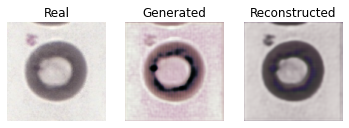

In [ ]:
# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

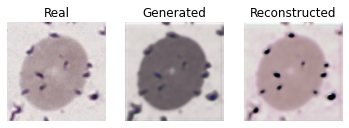

In [ ]:
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)